<a href="https://colab.research.google.com/github/hmatthews6/Thermal-Housing-Model/blob/main/Base_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

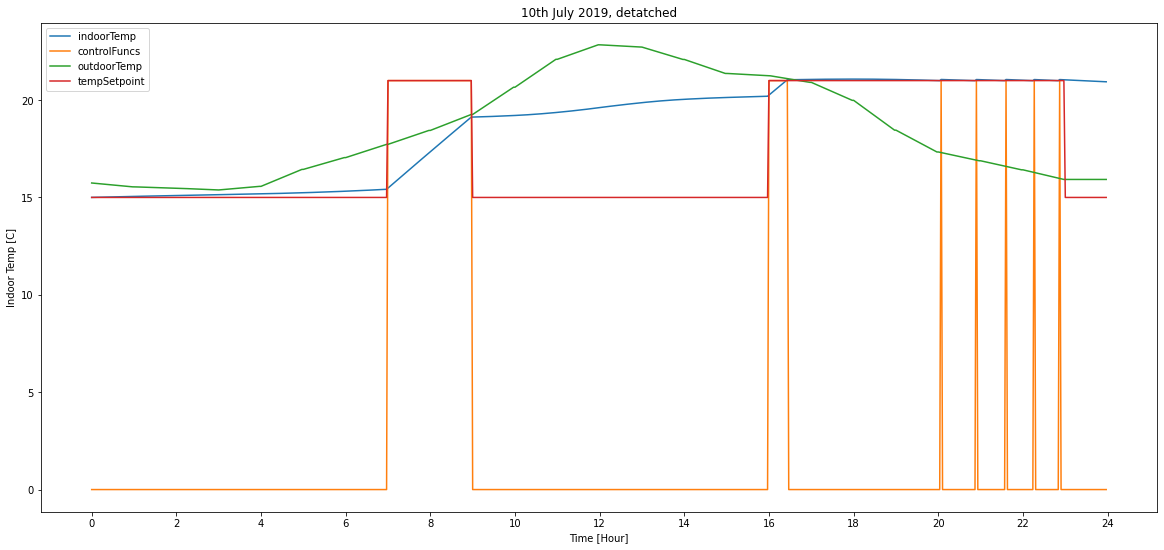

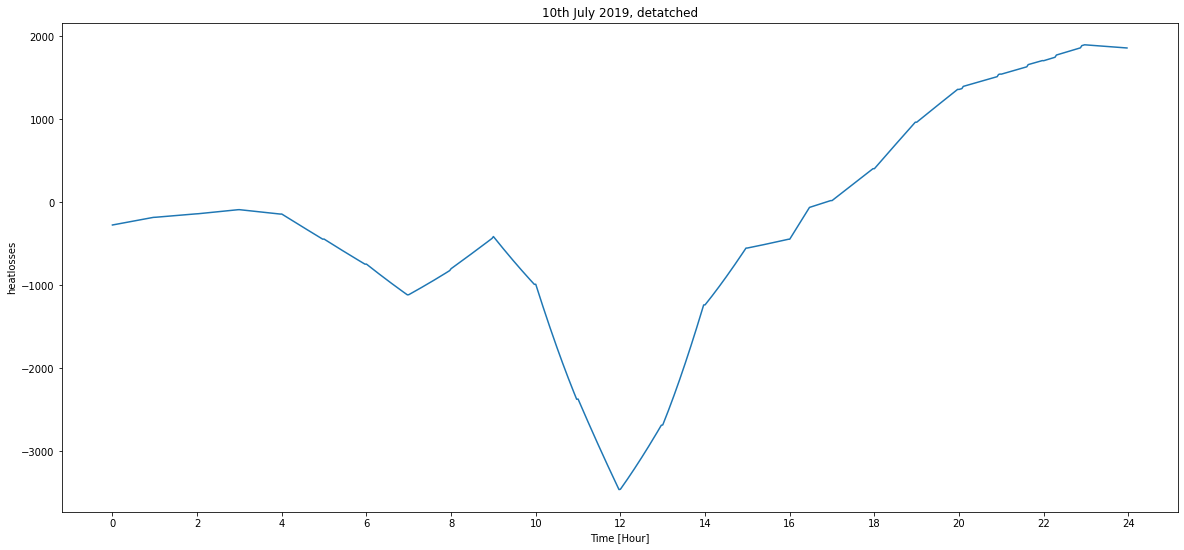

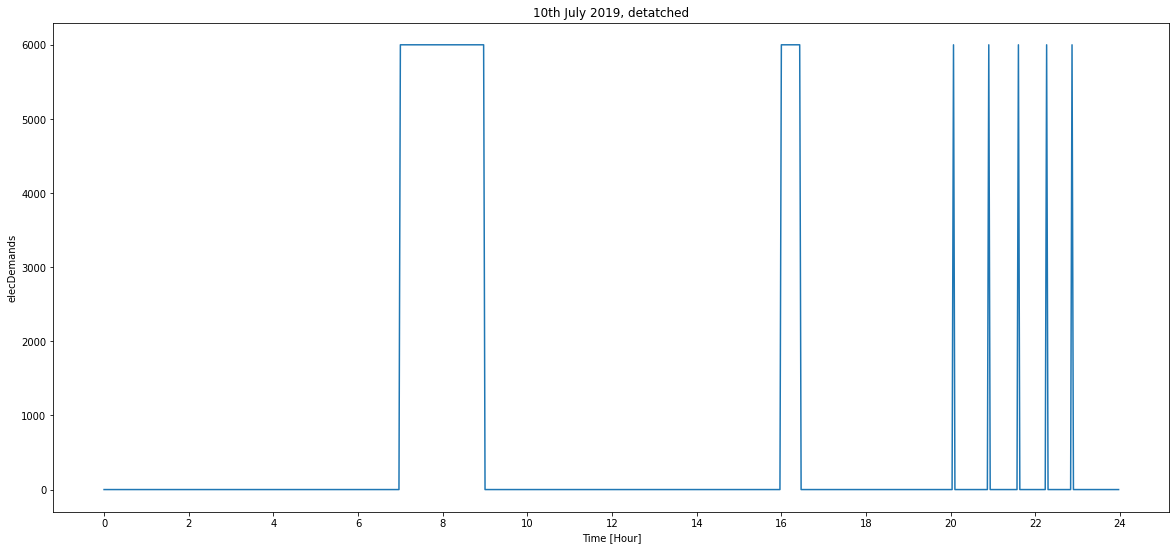

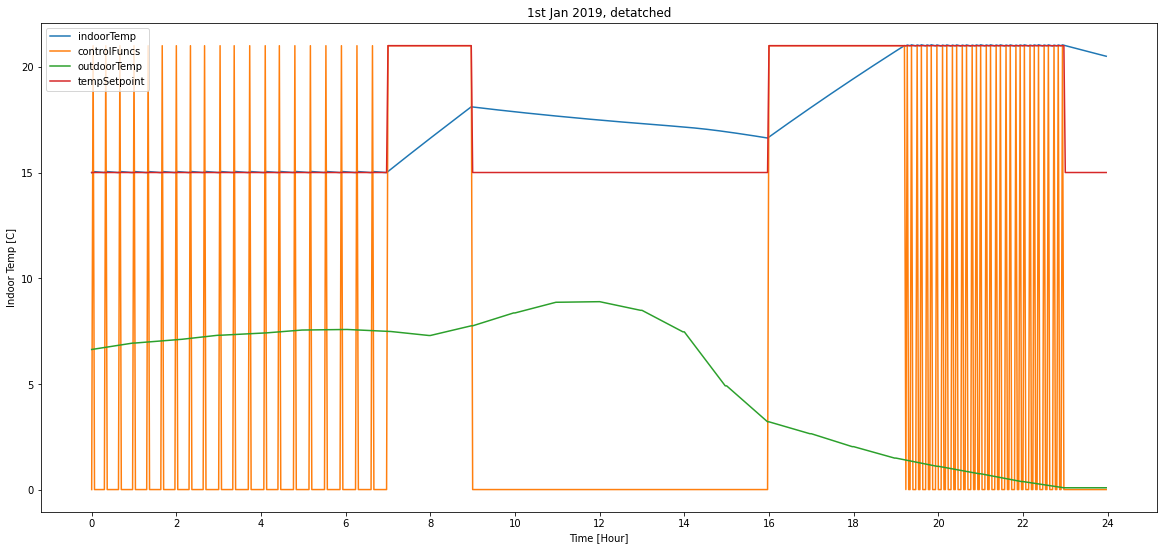

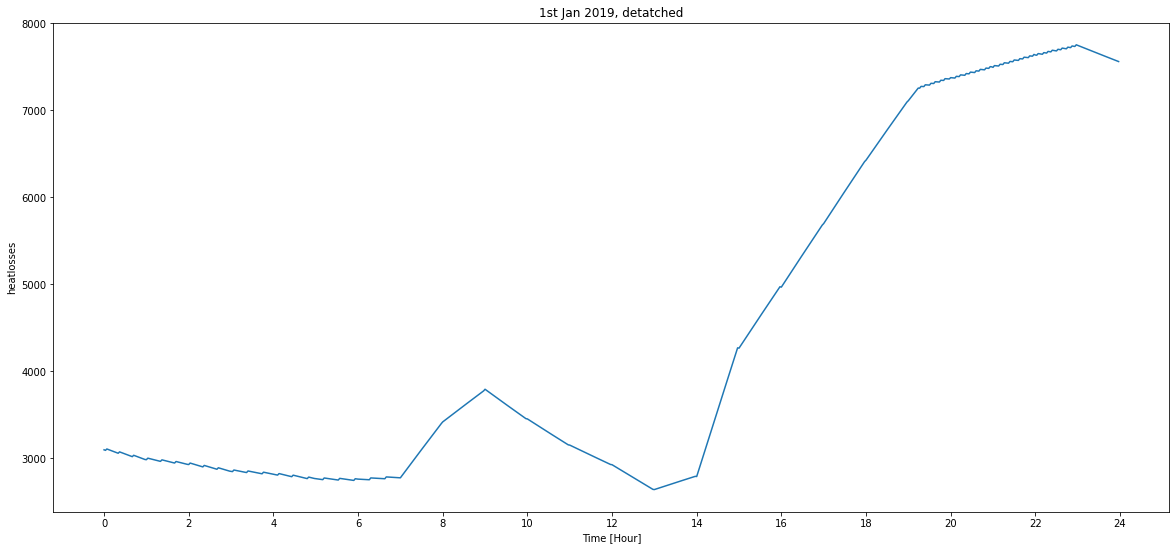

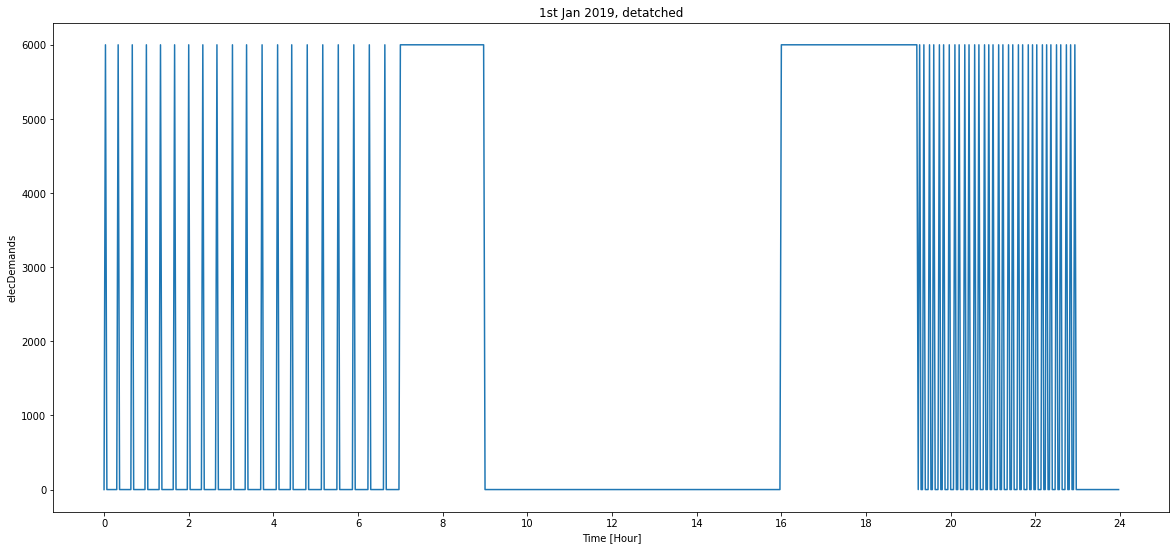

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#assumed starting values for the model:
coP = 4 #coefficient of performance of the heat pump
elecIn = 6000 #heat pump capacity [Watts]

#define house archetype by their thermal mass [J/K], U value [W/K], avg number of adults, avg number of children, solar aperture size [m^2]
detatched = { #divide each total solar aperture size by the number of exposed walls, as the sun can only hit an opening on one side at a time
    'thermalMass' : 49000000, #modelled as the air mass of the house
    'u' : 370, #thermal transmittance of the house
    'numAdults' : 1.95,
    'numChildren' : 0.5,
    'r' : 32/4
}
semidetatched = {
    'thermalMass' : 38000000,
    'u' : 260,
    'numAdults' : 1.88,
    'numChildren' : 0.61,
    'r' : 21/3
}
terraced = {
    'thermalMass' : 36000000,
    'u' : 200,
    'numAdults' : 1.77,
    'numChildren' : 0.70,
    'r' : 15/2
}

#variables that define residual heats:
occupancyProfile = [0.95, 0.95, 0.95, 0.95, 0.93, 0.85, 0.85, 0.75, 0.56, 0.49, 0.47, 0.47, 0.46, 0.46, 0.47, 0.52, 0.6, 0.69, 0.71, 0.76, 0.83, 0.88, 0.92, 0.94] #probability of person in house at any one time
bodyHeat = 50 #Watts (Joules/Sec)
cookingPerPerson = 23 #Watts (Later in the code, we add 5 for each extra person in the house due to cooking)

#variables that define the moodel's cycles
duration = 86400 #24hours in seconds
sampleRate =  120 #two minutes
numSamples = duration//sampleRate #sample over 24hours, ever two minutes, thus 720 samples

#number of samples / duration in hours = number of samples per hour
hourToSampleNum = numSamples//((duration//60)//60) #convert from say 9am to sample 270 (as sample 270 is when 9am starts in the list, and thus when the heating should go on)

#outdoor temperature data per hour for 2019 and solar gains data for 2019 (both from renewables ninja)
tOutData = pd.read_csv('https://raw.githubusercontent.com/hmatthews6/Thermal-Housing-Model-Data/main/ninjatempdata.csv')
sData = pd.read_csv('https://raw.githubusercontent.com/hmatthews6/Thermal-Housing-Model-Data/main/solarI.csv')
sAngleData = pd.read_csv('https://raw.githubusercontent.com/hmatthews6/Thermal-Housing-Model-Data/main/solarAngles.csv', index_col=False, names = ['Date', 'angle'])

#first part of the code is to calculate the inputs tSetpoint and tOutdoor

#goal is to output a list of temperatures at regular intervals throughout a certain number of hours (here we currently use every two mins over 24 hours)
#the temperature will either be tLow or tHigh based on when we define the heating is on

def CalcSetpoint(tLow, tHigh, times): #tLow and tHigh are integer temperatures, times is a list, where the first value is the time the heating gets set to tHigh, and the next time is when it gets set to tLow, and repeat
  """
  Calculate the setpoint of the house

  Parameters:
  ----------
  tLow: int
       the temperature [C] of the setpoint when the heating is set to low
  tHigh: int
       the temperature [C] of the setpoint when the heating is set to high
  times: list
       each set of two values in the list starting with the first two values determines a start and end time (in hours over one day) for the heating to be set to high

  Returns:
  --------
  tSet: list of type int
       list of setpoint temperatures [C] over a 24 hr period
  """

  global tSet

  tSet = [] #tSetpoint, 720 long list of temperature setpoints using 2 min intervals over 24 hrs [C]

  for i in range(numSamples):
    tSet.append(tLow) #set up this list as just being the outdoor temperature to begin with, then we can edit it after and change the times where we want heating on

  for e in range(0, len(times), 2): #for the times inputted, set the setpoint to tHigh
    start = times[e] * hourToSampleNum #get at what sample number the start/end hour is at
    end = times[e+1] * hourToSampleNum
    for f in range(start, end):
      tSet[f] = tHigh #during the period defined, change the setpoint to high

#now to create a list of varying tOuts and solar radiations over the same duration, with the same length as number of samples:

def CalcNinjaDataDate(date): #Date is a list, with the day, followed by the month (integers)
  """
  Selects the values from the Renewables ninja data relevant to a specific date, and converts them from a 24 long list of one value per hour into a smooth 720 long list of one value per 2mins

  Parameters:
  ----------
  date: list of type int
       day, month

  Returns:
  --------
  tOut: list of type int
       list of outdoor temperatures [C] over the 24 hr period of the date given
  s: list of type int
       list of solar heats [W] over the 24 hr period of the date given 
  sAngle: list of type int
       list of solar light angles [Radians] on the house over the 24 hr period
  """

  global tOut, s, sAngle

  months = [0,31,28,31,30,31,30,31,31,30,31,30,31] #days in each month
  startDate = 0 

  for i in range(date[1]): #loop to get start position of the date entered in ninja data (24 indicies for each day)
    startDate += months[i] * 24
  startDate = startDate + (date[0] - 1)  * 24

  tDataTemp, sDataSolar, sDataAngle = [], [], [] #get data from renewables data
  for i in range(25):
    tDataTemp.append(tOutData.loc[i+startDate, 'temperature'])
    sDataSolar.append(sData.loc[i+startDate, 'sI']*1000) #multiply by 1000 to go from kW to W
    sDataAngle.append(sAngleData.loc[i+startDate, 'angle'])

  tOut = [] #tOut, needs to be a 720 long list of outdoor temperatures over 24 hrs [C]
  s = [] #s also needs to be a 720 long list for solar gains over 24 hrs [W]
  sAngle = [] #same here, but the angle is actually accounted for and is now just a number between 0 and 1 that scales the solar gain value

  n=-1
  for i in range(numSamples): #make a list for outdoor temps as long as the number of samples
      if n < len(tDataTemp):
        if i % hourToSampleNum == 0:
          n+=1
          smoothedT = tDataTemp[n]
          tOut.append(tDataTemp[n]) #add hourly data at each hour

          smoothedS = sDataSolar[n]
          s.append(sDataSolar[n])

          smoothedSAngle = sDataAngle[n]
          sAngle.append(sDataAngle[n])
        else:
          if n == 23:
            next = tDataTemp[n]
            nextS = sDataSolar[n]
            nextSAngle = sDataAngle[n]
          else:
            next = tDataTemp[n+1]
            nextS = sDataSolar[n+1]
            nextSAngle = sDataAngle[n+1]
          smoothedT += (next-tDataTemp[n])/(hourToSampleNum-1)
          smoothedS += (nextS-sDataSolar[n])/(hourToSampleNum-1)
          smoothedSAngle += (nextSAngle-sDataAngle[n])/(hourToSampleNum-1)
          tOut.append(smoothedT) #add smooth inbetween values inbetween each hours Temp and solar gain
          s.append(smoothedS) 
          sAngle.append(smoothedSAngle)

def CalcApplianceHeat(houseType, month): #calculate the heat given off by appliances in the house
  """
  Calculate the residual heat produced by appliances in the house during a given mont

  Parameters:
  ----------
  houseType: dict
       house archetype (either detatched, semidetatched, or terraced)
  month: int
       which month we are running the model in
 
  Returns:
  --------
  applianceHeat: int
       the residual heat produced by all appliances in the house during a given month [Watts]
  """

  global applianceHeat
  
  months = [0,31,28,31,30,31,30,31,31,30,31,30,31] #days in each month

  if houseType == detatched:
    totalFloorArea = 142
  elif houseType == semidetatched:
    totalFloorArea = 95
  elif houseType == terraced:
    totalFloorArea = 84

  Ea = 207.8 * (totalFloorArea * (houseType['numAdults'] + houseType['numChildren']))**0.4714

  Eam = Ea * (1 + 0.157 * np.cos(2 * np.pi * (month - 1.78)/12)) * months[month] / 365

  applianceHeat = Eam * 1000 / (24 * months[month]) #[Watts]

#The model:
def RunModel(houseType, coP, elecIn): #thermal mass [J/K] affects how much heat the house actually absorbs in one cycle, coP Coefficient of performance ratio of useful heating provided to the work required
                                          #elecIn is the heatpump capacity, ie how much electricity it uses when on [Watts], U-value thermal transmittance (rate of transfer of heat through matter) [W/K]
  """
  Runs our thermal model over a 24 hour period for a given day, setpoint, house archetype, COP, and heat pump capacity

  Parameters:
  ----------
  houseType: dict
       house archetype (either detatched, semidetatched, or terraced)
  coP: int
       coefficient of performance of the heat pump
  elecIn: int
       heat pump capacity [Watts]

  Returns:
  --------
    outputTempData: pandas DataFrame
       a dataframe containing a 720 rows (each row representing one 2 min period of one day), columns are:
            indoorTemp: int
                 indoor temperature of the house [C]
            controlFuncs: int
                 value of 21 if the heatpump is on at a given time, 0 if not
            outdoorTemp: int
                 outdoor temperature at that time [C]
            tempSetpoint: int
                 the temperature setpoint of the heatpump at that time [C].
  outputData: pandas DataFrame
       a dataframe containing 720 rows (each row representing one 2 min period of one day), columns are:
            heatlosses: int
                 the heatloss of the house over that 2 min period [Watts]
            elecDemands: int
                 the electrical usage of the heatpump during that 2 min period [Watts].
  """

  global outputTempData, outputData
  
  thermalMass, U = houseType['thermalMass'], houseType['u']

  #reset variables
  heatlosses = [] #list of heatlosses
  temperatures = [] #list of inside temperatures over the time span of the day
  controlFuncs = [] #list of when the heating turns on or off over the total duration
  elecDemands = [] #list of electrical usage over the day
  tIn = 15 #[C] starting temperature
  timeStep = 120 #two minutes [s]
  m = -1 #hourly position in occupancy profile

  for i in range(len(tSet)): #loop over the number of cycles

      if (tIn < tSet[i]):     #determining controlFunc as to decide whether or not the heatpump is on in a given cycle
          controlFunc = 1
      else:
          controlFunc = 0

      controlFuncs.append(controlFunc * 21) #currently scaled to see it better on the graph
      
      if i % 30 == 0: #if we have passed one hour
        m += 1 #increment hour in occupancy profile
      residualHeat = (((bodyHeat + 5) * (houseType['numAdults'] + houseType['numChildren'])) + cookingPerPerson) * occupancyProfile[m] + applianceHeat #number of people * the heat they give off * the liklihood they are in the house at this time

      powerIn = coP * elecIn * controlFunc + residualHeat #useful heat from heatpump plus the residual heat

      powerOut = (tIn - tOut[i]) * U - (houseType['r']*s[i]*(np.sqrt(1-sAngle[i]**2))) #waste heat lost from house, minus the solar radiation heat gain

      dT = ((powerIn - powerOut) * timeStep) / thermalMass #change in temperature over one cycle

      heatlosses.append(powerOut)

      elecDemands.append(elecIn*controlFunc) #elec usage in watts

      tIn += dT #inside temperature chanegs by the change in temperature over one cycle
      temperatures.append(tIn)

  outputTempData = pd.DataFrame({'indoorTemp': temperatures, 'controlFuncs': controlFuncs, 'outdoorTemp': tOut, 'tempSetpoint': tSet})
  outputData = pd.DataFrame({'heatlosses': heatlosses, 'elecDemands': elecDemands})


#graphing:
def GraphResults(title, x=[i/30 for i in range(720)]):
  """
  Graphs the two output DataFrames from the function RunModel()

  Parameters:
  ----------
  title: string
       the title for the graph being produced

  Returns:
  --------
  displays a graph containing all the temperature data of the outputTempData DataFrame, with indoor temperature [C] on the y axis, and time [Hr] on the x axis
  displays two graphs from data in outputData DataFrame:
  displays a graph of heat losses on the y axis [Watts] against time [Hr] on the x axis
  displays a graph of electric usages on the y axis [Watts] against time [Hr] on the x axis
  """

  plt.figure(figsize=[20,9])
  plt.xlabel("Time [Hour]")
  plt.ylabel("Indoor Temp [C]")
  plt.xticks(np.arange(0, 25, step=2))
  plt.title(title)
  for name, values in outputTempData.items():
    plt.plot(x, values, label = name)
  plt.legend(loc='upper left')

  for name, values in outputData.items():
    plt.figure(figsize=[20,9])
    plt.xlabel("Time [Hour]")
    plt.ylabel(name)
    plt.xticks(np.arange(0, 25, step=2))
    plt.title(title)
    plt.plot(x, values, label = name)
    plt.show()

#testing the model works real quick
CalcSetpoint(15, 21, [7,9,16,23]) 

CalcNinjaDataDate([10, 7])
CalcApplianceHeat(detatched, 7)
RunModel(detatched, coP, elecIn)
GraphResults("10th July 2019, detatched")

CalcNinjaDataDate([1,1])
CalcApplianceHeat(detatched, 1)
RunModel(detatched, coP, elecIn)
GraphResults("1st Jan 2019, detatched")